## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



CPU times: user 33 s, sys: 285 ms, total: 33.3 s
Wall time: 33.5 s


In [5]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [6]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)

In [8]:
num_workers = 10
bs = 2
TextDataset = TextDataset5

In [9]:
bs_test = 2
test_loader = DataLoader(
    TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [10]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_2'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10
p_aug = 0.0

In [11]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Thu Jan  9 22:04:38 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


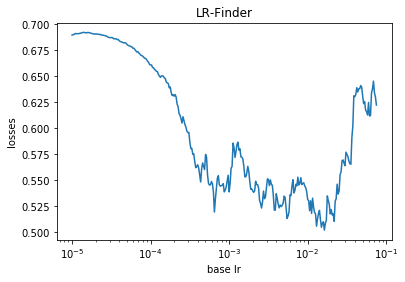

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50928 - spearmanr 0.24508
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47326 - spearmanr 0.38291


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.38291
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45628 - spearmanr 0.39511
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45539 - spearmanr 0.41153
best model: epoch 1 - 0.41153
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43223 - spearmanr 0.46089
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45249 - spearmanr 0.41509
best model: epoch 2 - 0.41509
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41062 - spearmanr 0.51438
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45465 - spearmanr 0.41641
best model: epoch 3 - 0.41641
TRAINING END: Best score achieved on epoch 3 - 0.41641
Starting inference for model: checkpoints/siamese_bert_2_fold_1_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_1_best.pth



Fold 2 started at Thu Jan  9 22:45:28 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50758 - spearmanr 0.24629
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47214 - spearmanr 0.39452
best model: epoch 0 - 0.39452
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45645 - spearmanr 0.39394
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45638 - spearmanr 0.41488
best model: epoch 1 - 0.41488
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43199 - spearmanr 0.46008
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45415 - spearmanr 0.42184
best model: epoch 2 - 0.42184
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40993 - spearmanr 0.51429
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45673 - spearmanr 0.41953
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42184
Starting inference for model: checkpoints/siamese_bert_2_fold_2_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_2_best.pth



Fold 3 started at Thu Jan  9 23:25:29 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50883 - spearmanr 0.24781
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47418 - spearmanr 0.37178
best model: epoch 0 - 0.37178
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45579 - spearmanr 0.39655
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45872 - spearmanr 0.39946
best model: epoch 1 - 0.39946
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43193 - spearmanr 0.46046
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45783 - spearmanr 0.40184
best model: epoch 2 - 0.40184
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40977 - spearmanr 0.51628
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46157 - spearmanr 0.39868
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40184
Starting inference for model: checkpoints/siamese_bert_2_fold_3_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_3_best.pth



Fold 4 started at Fri Jan 10 00:04:45 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50727 - spearmanr 0.25136
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47165 - spearmanr 0.36342
best model: epoch 0 - 0.36342
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45589 - spearmanr 0.39907
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45637 - spearmanr 0.39086
best model: epoch 1 - 0.39086
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43146 - spearmanr 0.46355
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45429 - spearmanr 0.40114
best model: epoch 2 - 0.40114
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40949 - spearmanr 0.51683
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45812 - spearmanr 0.39954
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40114
Starting inference for model: checkpoints/siamese_bert_2_fold_4_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_4_best.pth



Fold 5 started at Fri Jan 10 00:43:44 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50825 - spearmanr 0.25069
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.469 - spearmanr 0.37902
best model: epoch 0 - 0.37902
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45604 - spearmanr 0.39867
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45284 - spearmanr 0.39708
best model: epoch 1 - 0.39708
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43137 - spearmanr 0.46401
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45327 - spearmanr 0.40426
best model: epoch 2 - 0.40426
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40937 - spearmanr 0.51877
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45378 - spearmanr 0.40327
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40426
Starting inference for model: checkpoints/siamese_bert_2_fold_5_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_5_best.pth



Fold 6 started at Fri Jan 10 01:22:43 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.5096 - spearmanr 0.24839
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46421 - spearmanr 0.36811
best model: epoch 0 - 0.36811
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45565 - spearmanr 0.39931
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4558 - spearmanr 0.38824
best model: epoch 1 - 0.38824
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43183 - spearmanr 0.46317
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45032 - spearmanr 0.39416
best model: epoch 2 - 0.39416
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41036 - spearmanr 0.51599
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45342 - spearmanr 0.3931
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39416
Starting inference for model: checkpoints/siamese_bert_2_fold_6_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_6_best.pth



Fold 7 started at Fri Jan 10 02:01:42 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50817 - spearmanr 0.24993
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47169 - spearmanr 0.37193
best model: epoch 0 - 0.37193
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45539 - spearmanr 0.39788
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46107 - spearmanr 0.40546
best model: epoch 1 - 0.40546
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.4311 - spearmanr 0.46273
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45695 - spearmanr 0.41271
best model: epoch 2 - 0.41271
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40945 - spearmanr 0.51517
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45986 - spearmanr 0.41376
best model: epoch 3 - 0.41376
TRAINING END: Best score achieved on epoch 3 - 0.41376
Starting inference for model: checkpoints/siamese_bert_2_fold_7_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_7_best.pth



Fold 8 started at Fri Jan 10 02:40:42 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50896 - spearmanr 0.24463
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47326 - spearmanr 0.3857
best model: epoch 0 - 0.3857
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45519 - spearmanr 0.39657
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46545 - spearmanr 0.40577
best model: epoch 1 - 0.40577
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43127 - spearmanr 0.46101
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46216 - spearmanr 0.41644
best model: epoch 2 - 0.41644
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40906 - spearmanr 0.51667
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4665 - spearmanr 0.415
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41644
Starting inference for model: checkpoints/siamese_bert_2_fold_8_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_8_best.pth



Fold 9 started at Fri Jan 10 03:19:45 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50908 - spearmanr 0.24679
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47244 - spearmanr 0.37008
best model: epoch 0 - 0.37008
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45598 - spearmanr 0.39827
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45724 - spearmanr 0.39417
best model: epoch 1 - 0.39417
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43121 - spearmanr 0.46386
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45658 - spearmanr 0.40261
best model: epoch 2 - 0.40261
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40949 - spearmanr 0.51649
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45834 - spearmanr 0.40457
best model: epoch 3 - 0.40457
TRAINING END: Best score achieved on epoch 3 - 0.40457
Starting inference for model: checkpoints/siamese_bert_2_fold_9_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_9_best.pth



Fold 10 started at Fri Jan 10 03:58:54 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50977 - spearmanr 0.24504
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.45938 - spearmanr 0.38943
best model: epoch 0 - 0.38943
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.4574 - spearmanr 0.39487
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.4493 - spearmanr 0.41487
best model: epoch 1 - 0.41487
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43244 - spearmanr 0.46153
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4472 - spearmanr 0.42022
best model: epoch 2 - 0.42022
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41073 - spearmanr 0.51562
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44773 - spearmanr 0.42087
best model: epoch 3 - 0.42087
TRAINING END: Best score achieved on epoch 3 - 0.42087
Starting inference for model: checkpoints/siamese_bert_2_fold_10_best.pth



Starting inference for model: checkpoints/siamese_bert_2_fold_10_best.pth



OOF score: 0.4090897278226744


In [12]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#KFold 5: distilbert: 0.4160
#GKFold 5: distilbert: ~0.4005, ~0.4130, distilbert eda: ~0.4000, ~0.4200 (unsure), bert siamese: 0.4040, 0.4188
    # smoothing y dist -> ~0.005 CV improve
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese(smoothing): 0.4059, 0.4206, 0.4275, 0.4449
    #bert siamese(smoothing) with token_type_ids: 0.4091. 0.4236. 0.4317, 0.4507
#MLFold 5: bert siamese: 0.4118, 0.4355, 04373

In [13]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

def scale(x, d):
    if d: return (x//(1/d))/d
    else: return x

indices = [2, 5, 12, 13, 14, 15]
ds = [10, 5, 5, 20, 5, 5]
discrete_cols = np.array(TARGETS)[indices]
print(discrete_cols)

def ahmet_round(preds, ds=ds, indices=indices):
    new_preds = preds.copy()
    for idx, d in zip(indices, ds):
        new_preds[:,idx] = scale(preds[:,idx], d)
    return new_preds

['question_conversational' 'question_has_commonly_accepted_answer'
 'question_type_compare' 'question_type_consequence'
 'question_type_definition' 'question_type_entity']


In [14]:
from scipy.stats import spearmanr
opt_ds = []
opt_indices = []
for idx in range(N_TARGETS):
    opt_score = 0
    opt_d = None
    for d in [3, 5, 10, 15, 20, 33, None]:
        score = spearmanr(scale(oofs[:,idx], d), y[:,idx])[0]
        if score > opt_score:
            opt_score = score
            opt_d = d
            print(idx, d, score)
    if opt_d:
        opt_ds.append(opt_d)
        opt_indices.append(idx)

0 3 0.3221872566673915
0 5 0.3561507197672725
0 10 0.3830822303332714
0 20 0.3838784722417429
1 3 0.6178644327496574
1 5 0.6480706592745699
1 10 0.6570792411733124
1 15 0.6596491416449423
1 33 0.6604923882315796
1 None 0.6605479757388907
2 3 0.460287710318177
2 5 0.478730484569678
2 10 0.48531659985146586
3 3 0.26620332343059055
3 5 0.2842171943343365
3 10 0.29693692409464656
3 15 0.302280294214101
3 20 0.3050521090297004
3 33 0.30559123301882335
4 3 0.31562312831794015
4 5 0.3523816679611844
4 10 0.3592641961476965
5 3 0.46515871856092295
6 3 0.2611726065066631
6 5 0.3263062245236877
6 10 0.35022684666714526
6 15 0.35697896232374404
6 20 0.3580794192574331
7 3 0.4860161085005432
7 5 0.5074876580683119
7 10 0.5097259075566957
7 15 0.5118953520480538
7 33 0.5121987574219725
7 None 0.5123665320529436
8 3 0.558406836292983
8 5 0.5740980565783937
8 10 0.5753048575997075
8 15 0.5779264560099703
9 10 0.055951946172034805
9 20 0.12091885021126554
9 33 0.12203169051262261
10 3 0.44846593675353

In [25]:
opt_ds, opt_indices

([20,
  10,
  33,
  10,
  3,
  20,
  15,
  33,
  15,
  5,
  10,
  3,
  5,
  10,
  15,
  15,
  15,
  33,
  15,
  15,
  20],
 [0, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 26])

In [16]:
spearmanr_np(ahmet_round(oofs, opt_ds, opt_indices), y)

0.4507479298661807

In [17]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0
spearmanr_np(ahmet_round(oofs_alt, opt_ds, opt_indices), y)
#GKFold 10: distilbert: 0.4012, ~0.4195, bert siamese(smoothing): 0.4091. 0.4236. 0.4317, 0.4507

0.4507479298661807

In [18]:
spearmanr_np(oofs, y)

0.4090897278226744

In [19]:
spearmanr_np(round_preds(oofs, high_num=3), y)

0.42360696711765006

In [20]:
spearmanr_np(ahmet_round(oofs), y)

0.43165986643228116

In [21]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [22]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.833790,0.604779,0.383779,0.398541,0.538318,0.397372,0.700065,0.695887,0.717458,0.004995,0.701551,0.762140,0.023097,0.500477,0.006941,0.017644,0.083373,0.172486,0.754095,0.000729,0.832300,0.610186,0.215918,0.757517,0.727119,0.349516,0.020657,0.040756,0.799499,0.607527
1,46,0.470189,0.311983,0.010144,0.670133,0.626230,0.859610,0.421996,0.361882,0.045686,0.016028,0.485502,0.203191,0.003879,0.000501,0.000657,0.013879,0.893647,0.320556,0.073908,0.000134,0.250339,0.770121,0.475813,0.861309,0.926336,0.578109,0.945705,0.200283,0.037136,0.608021
2,70,0.684507,0.540852,0.037645,0.634292,0.802562,0.909983,0.497290,0.391125,0.304839,0.003971,0.292018,0.683465,0.016925,0.062489,0.001494,0.005255,0.143514,0.136949,0.765818,0.000342,0.632941,0.685117,0.314562,0.839117,0.842374,0.491926,0.048668,0.062430,0.854571,0.547625
3,132,0.572175,0.174366,0.006001,0.613435,0.650546,0.862992,0.385646,0.240905,0.193425,0.009382,0.571493,0.164651,0.001890,0.004019,0.000416,0.002692,0.791027,0.306042,0.653481,0.000072,0.459519,0.810996,0.599712,0.870500,0.920179,0.660394,0.846348,0.341721,0.646522,0.663862
4,200,0.782268,0.285774,0.056976,0.805076,0.711119,0.859054,0.693134,0.732294,0.186987,0.035791,0.349274,0.569882,0.008184,0.025877,0.010853,0.071352,0.185624,0.191357,0.532056,0.003800,0.376976,0.745034,0.550545,0.871293,0.873801,0.632389,0.231487,0.217359,0.684828,0.623611
